# Estimación del MIC con métodos de clasificación ordinal

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold

from sklearn.datasets import load_diabetes
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import LabelEncoder

from ordinal_class import OrdinalClassifier
from camda_functions import get_X_y_ordinal, split_stratified_into_train_val_test, search_params_ordinal, ordinal_clas_stat, results_report

Pipeline con datos completos (AMR count)
- Encoding TF-IDF
- Factorización SVD y NMF con *p* componentes
- Baseline: regresión lineal múltiple y RF para clasificacion o regresion
- Clasificadores ordinales basados en los siguientes clasificadores base:
    - Regresión Logística
    - CART
    - Random Forests
    - Neural Networks con recodificación ordinal de $y$
- Comparación de resultados

## Meropenem Loose

In [54]:
os.getcwd()

'/Users/vmac/cursos/estadistica_microbiomas/2024/camda2024/repo_octubre/Camda24_resistance/Notebooks'

### Variables $(\mathbf{X}, \mathbf{y})$

- Se obtiene la variable independiente $X$ según el pipeline (TF-IDF -> LSA/NMF) para train y test
- Se obtiene la variable dependiente $y$ para train y test, con el MIC recategorizado según ciertos bins. Se convierte a una variable categórica tipo string y también, se codifica como una variable int mediante un label encoder (le), que también se devuelve
- Adicinoalmente, se devuelven los metadatos para train y test, que contienen los valores originales del MIC

In [47]:
ruta_data = '/Users/vmac/cursos/estadistica_microbiomas/2024/camda2024/repo_octubre/Camda24_resistance/DataSets/'
# ['CiprofloxacinLoose', 'CiprofloxacinStrict', 'MeropenemLoose', 'MeropenemStriect']
data_label = 'MeropenemLoose'
X_nombre_archivo = 'Resistance' + data_label + '.tsv.gz' 
Y_nombre_archivo = "MIC_categorizado"

ruta_fact = '/Users/vmac/cursos/estadistica_microbiomas/2024/camda2024/repo_octubre/Camda24_resistance/Notebooks/' # si hay alguna factorización guardada...
n_comp = 100 #cuántos componentes?

metadata, metadata_tr, metadata_te, tfidf_train, tfidf_test, tfidf_vect, amr_train_lsa, amr_train_nmf, amr_test_lsa, amr_test_nmf, y, y_cat, le = \
    get_X_y_ordinal(ruta_data, X_nombre_archivo, Y_nombre_archivo, data_label, False, True, ruta_fact, n_comp)


### Conteo de los valores MIC

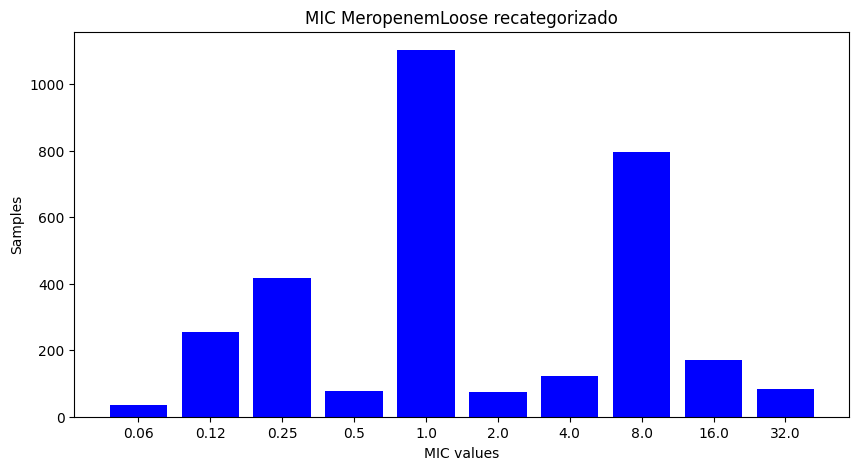

In [4]:
counts_mic = pd.DataFrame(metadata_tr['mic_recat'].value_counts())
counts_mic['mic_values'] = counts_mic.index
counts_mic['str_mic'] = [str(val) for val in counts_mic['mic_values']]
counts_mic = counts_mic.sort_values('mic_values')

plt.figure(figsize=(10,5))
plt.bar(counts_mic['str_mic'], counts_mic['count'], color ='blue', width = 0.8)
plt.title('MIC ' + data_label + ' recategorizado')
plt.xlabel("MIC values")
plt.ylabel("Samples")
plt.show()


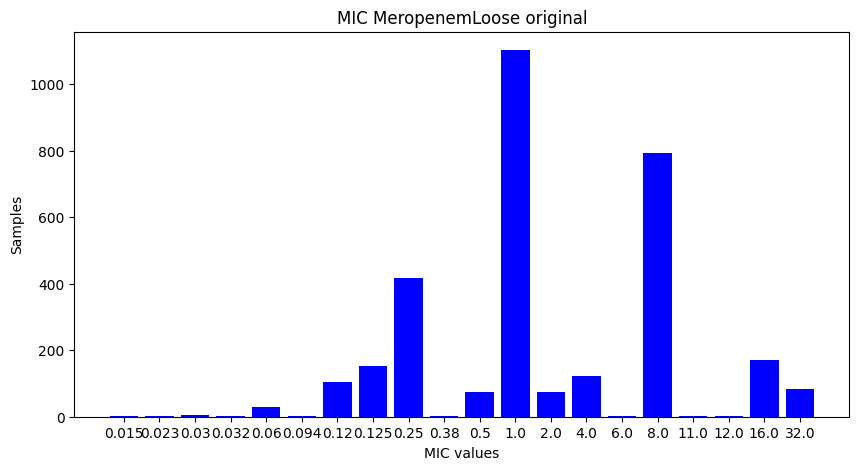

In [5]:
counts_mic = pd.DataFrame(metadata_tr['mic'].value_counts())
counts_mic['mic_values'] = counts_mic.index
counts_mic['str_mic'] = [str(val) for val in counts_mic['mic_values']]
counts_mic = counts_mic.sort_values('mic_values')

plt.figure(figsize=(10,5))
plt.bar(counts_mic['str_mic'], counts_mic['count'], color ='blue', width = 0.8)
plt.title('MIC ' + data_label + ' original')
plt.xlabel("MIC values")
plt.ylabel("Samples")
plt.show()

<Figure size 640x480 with 0 Axes>

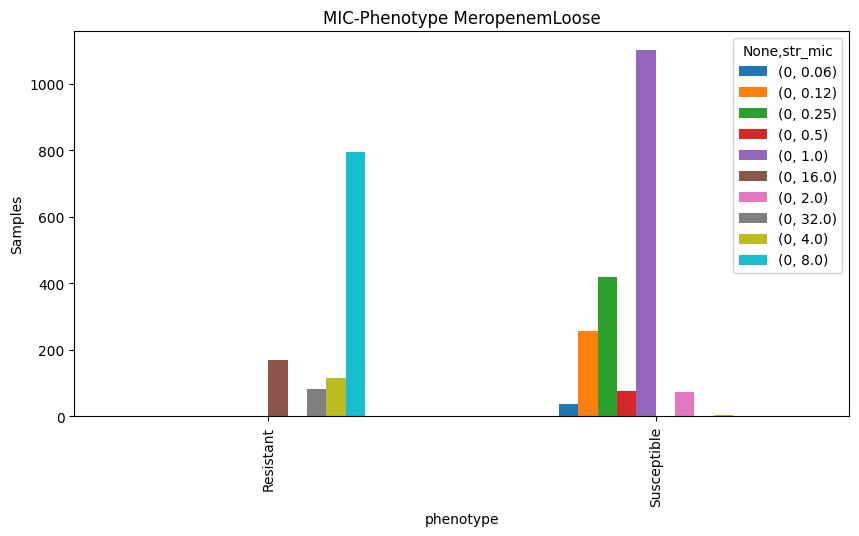

In [6]:
summary = pd.DataFrame(metadata.groupby(['phenotype','str_mic']).size())
plt.figure()
summary.unstack().plot.bar(figsize=(10,5))
plt.title('MIC-Phenotype ' + data_label)
plt.ylabel("Samples")
plt.show()


### Clasificación

Se obtienen datos de entrenamiento y prueba

In [48]:
X_tr = amr_train_lsa

X_train, y_train, __, __, X_test, y_test, class_w, __ = split_stratified_into_train_val_test(X_tr, y_cat, .80, 0, .20, 
                                                                                                std=False, two_subsets=True, random_state=42)
# para formar la variable de respuesta del problema de regresión, se pueden elegir dos opciones de MIC:
# - el 'mic' original, posiblemente con más valores diferentes que los considerados en las categorias ordinales (se reagruparon los valores poco frecuentes)
# - el recategorizado 'mic_recat', donde se reagruparon los valores poco frecuentes de concentración
y_train_reg = metadata_tr.loc[X_train.index]['mic_recat']
y_test_reg = metadata_tr.loc[X_test.index]['mic_recat']

Pipeline propuesto:
1. Datos completos
- TF-IDF
- Factorización SVD o NMF con *p* componentes
- Visualización de baja dimensión
- Baseline: regresión lineal múltiple y RF para clasificacion o regresion
- Clasificadores ordinales:
    - Reg. Log.
    - CART
    - RF
    - NN
- Comparación de resultados

2. Datos seleccionados
- TF-IDF
- Selección de variables usando
    - RF
    - RFE
- Factorización SVD o NMF con *p* componentes
- Visualización de baja dimensión
- Baseline: regresión lineal múltiple y RF para clasificacion o regresion
- Clasificadores ordinales:
    - Reg. Log.
    - CART
    - RF
    - NN
- Comparación de resultados

#### Visualizaciones de baja dimensión

In [11]:
lab = 'str_mic'
lab2 = 'phenotype'
embedding = amr_train_lsa
reduced_proj = pd.DataFrame({'x1': embedding.iloc[:,0], 'x2': embedding.iloc[:,1], 'label': metadata_tr[lab], 'label2': metadata_tr[lab2]})
fig = px.scatter(reduced_proj, x='x1', y='x2', hover_data='label2', color = 'label', title='reduced plot')
fig.update_layout(autosize=False, width=700, height=700)
fig.show()

In [12]:
embedding = amr_train_nmf
reduced_proj = pd.DataFrame({'x1': embedding.iloc[:,0], 'x2': embedding.iloc[:,1], 'label': metadata_tr[lab], 'label2': metadata_tr[lab2]})
fig = px.scatter(reduced_proj, x='x1', y='x2', hover_data='label2', color = 'label', title='reduced plot')
fig.update_layout(autosize=False, width=700, height=700)
fig.show()

In [16]:
import umap.umap_ as umap

reducer = umap.UMAP(n_neighbors=25, n_components=3, min_dist=.8, metric='cosine')
#embedding = reducer.fit_transform(amr_train_lsa)
embedding = reducer.fit_transform(tfidf_train)

In [17]:
umap_proj = pd.DataFrame({'x1': embedding[:,0], 'x2': embedding[:,1], 'label': metadata_tr[lab], 'label2': metadata_tr[lab2]})
fig = px.scatter(umap_proj, x='x1', y='x2', hover_data='label2', color = 'label', title='UMAP plot')
fig.update_layout(autosize=False, width=700, height=700)
fig.show()

#### Baselines y clasificación ordinal

In [49]:
# linear model
from sklearn.linear_model import LinearRegression 

# CART
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree

# Boosting
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.tree import DecisionTreeClassifier

# Bagging
from sklearn.ensemble import BaggingClassifier

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Logistic Regression
from sklearn.linear_model import LogisticRegression

Baselines

In [20]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train_reg)
y_pred = linear_reg.predict(X_test)
mae = mean_absolute_error(y_test_reg, y_pred)
rmse = root_mean_squared_error(y_test_reg, y_pred)
print('MAE: ', mae, '. RMSE: ',rmse)

MAE:  3.2236423235885163 . RMSE:  5.221813648961342


In [22]:
cart_reg = DecisionTreeRegressor().fit(X_train, y_train_reg)
y_pred = cart_reg.predict(X_test)
mae = mean_absolute_error(y_test_reg, y_pred)
rmse = root_mean_squared_error(y_test_reg, y_pred)
print('MAE: ', mae, '. RMSE: ',rmse)

MAE:  2.9397767145135565 . RMSE:  6.485989095385109


## Regresión logística ordinal

In [25]:
# Definir los parámetros para GridSearchCV
param_grid = {
    'clf__C': [0.01, 0.1, 1, 2, 3, 4, 5, 10, 15],
    'clf__penalty': ['l1', 'l2', 'elasticnet']
}
# Crear instancia del clasificador con Logistic Regression
LR = LogisticRegression(max_iter=5000, solver='saga')
# Crear instancia de OrdinalClassifier con Logistic Regression como clasificador base
ordinal_clf = OrdinalClassifier(LR)
cv = 5
best_params, best_score = search_params_ordinal(ordinal_clf, X_train, y_train, param_grid, cv)
print("Mejores hiperparámetros:", best_params)
print("Mejor puntuación:", best_score)

Mejores hiperparámetros: {'clf__C': 5, 'clf__penalty': 'l1'}
Mejor puntuación: 0.6334160364529904


In [26]:
# Realiza K-FOLD CV para obtener estadísticas de desempeño
LR = LogisticRegression(max_iter=5000, C = best_params['clf__C'], penalty = best_params['clf__penalty'], solver = 'saga')
# Crear una nueva instancia de OrdinalClassifier con los parámetros óptimos
best_model = OrdinalClassifier(LR)

n_repeats = 10
sc='neg_mean_absolute_error' #MAE
mean_score, std_score, cv_scores = ordinal_clas_stat(best_model, X_train, y_train, sc, rand_state = 42, n_repeats=n_repeats)
# Imprimir los resultados de la validación cruzada
print("CV-",len(cv_scores),' Folds')
print(f"MAE: {mean_score:.3f} +/- {std_score:.3f}")


CV- 50  Folds
MAE: 1.237 +/- 0.101


In [27]:
sc='neg_root_mean_squared_error' #RMSE
mean_score, std_score, cv_scores = ordinal_clas_stat(best_model, X_train, y_train, sc, rand_state = 42, n_repeats=n_repeats)

# Imprimir los resultados de la validación cruzada
print("CV-",len(cv_scores),' Folds')
print(f"RMSE: {mean_score:.3f} +/- {std_score:.3f}")

CV- 50  Folds
RMSE: 2.352 +/- 0.102


MAE:  1.386 
RMSE:  2.569
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.58      0.14      0.22        51
           2       0.57      0.70      0.63        84
           3       0.09      0.07      0.08        15
           4       0.67      0.86      0.75       221
           5       0.52      0.38      0.44        34
           6       0.29      0.13      0.18        15
           7       0.40      0.35      0.38        17
           8       0.60      0.12      0.21        24
           9       0.60      0.63      0.62       159

    accuracy                           0.61       627
   macro avg       0.43      0.34      0.35       627
weighted avg       0.58      0.61      0.57       627



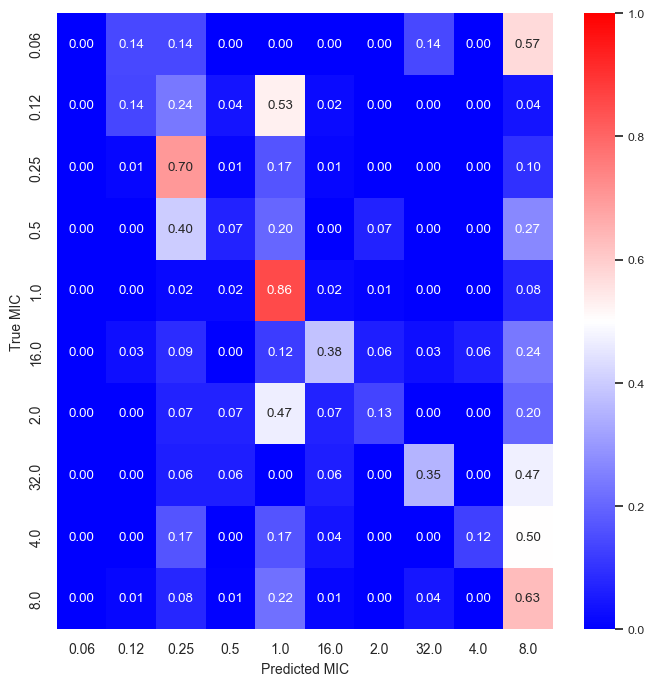

In [30]:
# entrena el modelo con los parámetros óptimos y hace la predicción en los datos de test
best_model.fit(X_train, y_train)
# Predecir etiquetas
y_hat = best_model.predict(X_test)

results_report(y_test, y_hat, le)

## CART ordinal

In [31]:
# Definir los parámetros para GridSearchCV
param_grid = {
    'clf__criterion': ['gini', 'entropy', 'log_loss'],
    'clf__ccp_alpha': [0.1, 0.01, 0.05, 0.001, 0.005, 0.0001, 0.0005],
    'clf__max_features': ['auto', 'sqrt', 'log2'],
}
# Crear instancia del clasificador
DT = DecisionTreeClassifier()
# Crear instancia de OrdinalClassifier 
ordinal_clf = OrdinalClassifier(DT)
cv = 5
best_params, best_score = search_params_ordinal(ordinal_clf, X_train, y_train, param_grid, cv)
print("Mejores hiperparámetros:", best_params)
print("Mejor puntuación:", best_score)

Mejores hiperparámetros: {'clf__ccp_alpha': 0.005, 'clf__criterion': 'log_loss', 'clf__max_features': 'sqrt'}
Mejor puntuación: 0.5018043594086727


In [32]:
# Crear una nueva instancia del clasificador ordinal
DT = DecisionTreeClassifier(ccp_alpha = best_params['clf__ccp_alpha'],
                            criterion = best_params['clf__criterion'],
                            max_features = best_params['clf__max_features'])

# Crear una nueva instancia de OrdinalClassifier con LogisticRegression actualizado
best_model = OrdinalClassifier(DT)

n_repeats = 10
sc='neg_mean_absolute_error'
mean_score, std_score, cv_scores = ordinal_clas_stat(best_model, X_train, y_train, score=sc, rand_state = 42, n_repeats=n_repeats)
# Imprimir los resultados de la validación cruzada
print("CV-",len(cv_scores),' Folds')
print(f"MAE: {mean_score:.3f} +/- {std_score:.3f}")

CV- 50  Folds
MAE: 1.472 +/- 0.072


In [33]:
sc='neg_root_mean_squared_error' #RMSE
mean_score, std_score, cv_scores = ordinal_clas_stat(best_model, X_train, y_train, score=sc, rand_state = 42, n_repeats=n_repeats)

# Imprimir los resultados de la validación cruzada
print("CV-",len(cv_scores),' Folds')
print(f"RMSE: {mean_score:.3f} +/- {std_score:.3f}")

CV- 50  Folds
RMSE: 2.412 +/- 0.111


MAE:  1.474 
RMSE:  2.405
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.44      0.08      0.13        51
           2       0.59      0.48      0.53        84
           3       0.06      0.13      0.08        15
           4       0.60      0.76      0.67       221
           5       0.25      0.47      0.32        34
           6       0.06      0.07      0.06        15
           7       0.18      0.29      0.22        17
           8       0.12      0.12      0.12        24
           9       0.71      0.45      0.55       159

    accuracy                           0.49       627
   macro avg       0.30      0.29      0.27       627
weighted avg       0.53      0.49      0.49       627



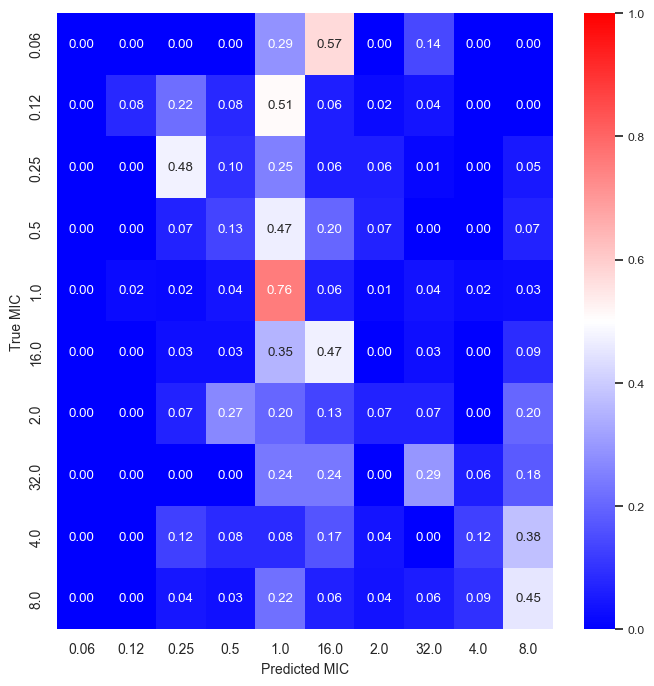

In [34]:
# entrena el modelo con los parámetros óptimos y hace la predicción en los datos de test
best_model.fit(X_train, y_train)
# Predecir etiquetas
y_hat = best_model.predict(X_test)

results_report(y_test, y_hat, le)

## Random Forests ordinal

In [35]:
# Definir los parámetros para GridSearchCV
param_grid = {
    'clf__n_estimators': [50, 100, 200, 500],
    'clf__criterion': ['gini', 'entropy', 'log_loss'],
    'clf__class_weight': ['balanced', 'balanced_subsample'],
    'clf__ccp_alpha': [0.1, 0.01, 0.05, 0.001, 0.005, 0.0001, 0.0005],
    'clf__max_features': ['sqrt', 'log2']
}

# Crear instancia del clasificador
RF = RandomForestClassifier()
# Crear instancia de OrdinalClassifier 
ordinal_clf = OrdinalClassifier(RF)
cv = 5
best_params, best_score = search_params_ordinal(ordinal_clf, X_train, y_train, param_grid, cv)
print("Mejores hiperparámetros:", best_params)
print("Mejor puntuación:", best_score)

Mejores hiperparámetros: {'clf__ccp_alpha': 0.001, 'clf__class_weight': 'balanced_subsample', 'clf__criterion': 'log_loss', 'clf__max_features': 'sqrt', 'clf__n_estimators': 500}
Mejor puntuación: 0.6780916255139124


In [37]:
# Crear una nueva instancia del clasificador ordinal
RF = RandomForestClassifier(n_estimators = best_params['clf__n_estimators'],
                            criterion = best_params['clf__criterion'],
                            class_weight = best_params['clf__class_weight'],
                            ccp_alpha = best_params['clf__ccp_alpha'],
                            max_features = best_params['clf__max_features'])

# Crear una nueva instancia de OrdinalClassifier con LogisticRegression actualizado
best_model = OrdinalClassifier(RF)

n_repeats = 10
sc='neg_mean_absolute_error'
mean_score, std_score, cv_scores = ordinal_clas_stat(best_model, X_train, y_train, score=sc, rand_state = 42, n_repeats=n_repeats)

# Imprimir los resultados de la validación cruzada
print("CV-",len(cv_scores),' Folds')
print(f"MAE: {mean_score:.3f} +/- {std_score:.3f}")

CV- 50  Folds
MAE: 1.111 +/- 0.075


In [38]:
sc='neg_root_mean_squared_error' #RMSE
mean_score, std_score, cv_scores = ordinal_clas_stat(best_model, X_train, y_train, score=sc, rand_state = 42, n_repeats=n_repeats)

# Imprimir los resultados de la validación cruzada
print("CV-",len(cv_scores),' Folds')
print(f"RMSE: {mean_score:.3f} +/- {std_score:.3f}")

CV- 50  Folds
RMSE: 2.263 +/- 0.108


MAE:  1.193 
RMSE:  2.42
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.59      0.31      0.41        51
           2       0.61      0.74      0.67        84
           3       0.13      0.13      0.13        15
           4       0.74      0.87      0.80       221
           5       0.76      0.47      0.58        34
           6       0.25      0.13      0.17        15
           7       0.67      0.59      0.62        17
           8       0.57      0.17      0.26        24
           9       0.68      0.71      0.70       159

    accuracy                           0.67       627
   macro avg       0.50      0.41      0.43       627
weighted avg       0.65      0.67      0.65       627



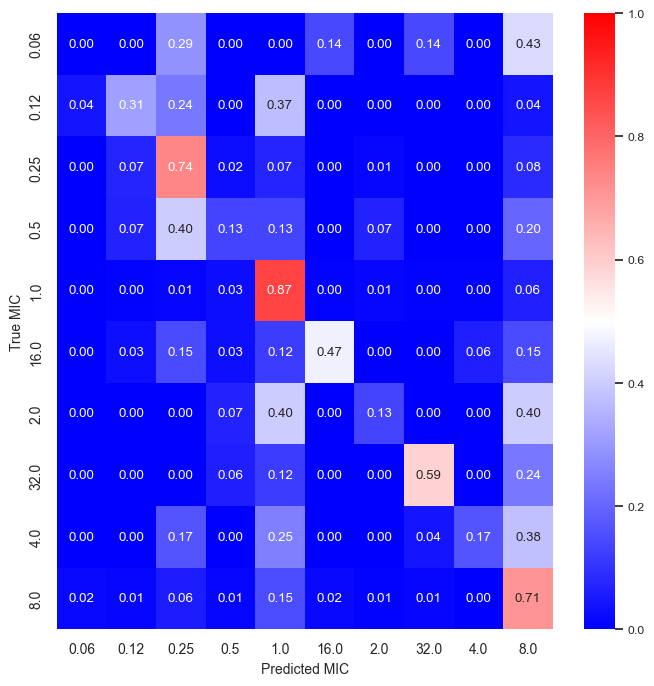

In [39]:
best_model.fit(X_train, y_train)
# Predecir etiquetas
y_hat = best_model.predict(X_test)

results_report(y_test, y_hat, le)

## Red neuronal ordinal

In [50]:
from camda_functions import ordinal_encoding_nn, prediction2label_nn, cross_val_metrics_nn

X_train_np = np.array(X_train)
X_test_np = np.array(X_test)

# recodificar la variable de respuesta con un encoding ordinal
n_clas = len(le.classes_)
n_var = X_train_np.shape[1]
y_tr_oc = ordinal_encoding_nn(y_train, n_clas)
y_te_oc = ordinal_encoding_nn(y_test, n_clas)

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import activations

# Crear una instancia del modelo
model = Sequential()
#model.add(Dropout(0.2, input_shape = (n_var,)))
#model.add(Dense(80, activation='relu'))
model.add(Dense(80, input_dim=n_var, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(60, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(30, activation='relu'))
model.add(Dense(n_clas, activation='sigmoid'))  # Output layer with 5 units for target representation

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam')

In [43]:
# Cross validation
cv = 5
mae_mean, mae_std, rmse_mean, rmse_std = cross_val_metrics_nn(model, X_train_np, y_tr_oc, cv)
# Imprimir los resultados
print(f"MAE: {mae_mean} +/- {mae_std}")
print(f"RMSE: {rmse_mean} +/- {rmse_std}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
MAE: 0.611055180475702 +/- 0.0986397952822121
RMSE: 1.4368153709206806 +/- 0.17638234222383944


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
MAE:  1.064 
RMSE:  2.063
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       1.00      0.04      0.08        51
           2       0.52      0.71      0.60        84
           3       0.05      0.07      0.05        15
           4       0.75      0.82      0.79       221
           5       0.38      0.53      0.44        34
           6       0.10      0.13      0.11        15
           7       0.23      0.18      0.20        17
           8       0.00      0.00      0.00        24
           9       0.74      0.75      0.74       159

    accuracy                           0.62       627
   macro avg       0.38      0.32      0.30       627
weighted avg       0.63      0.62      0.59       627



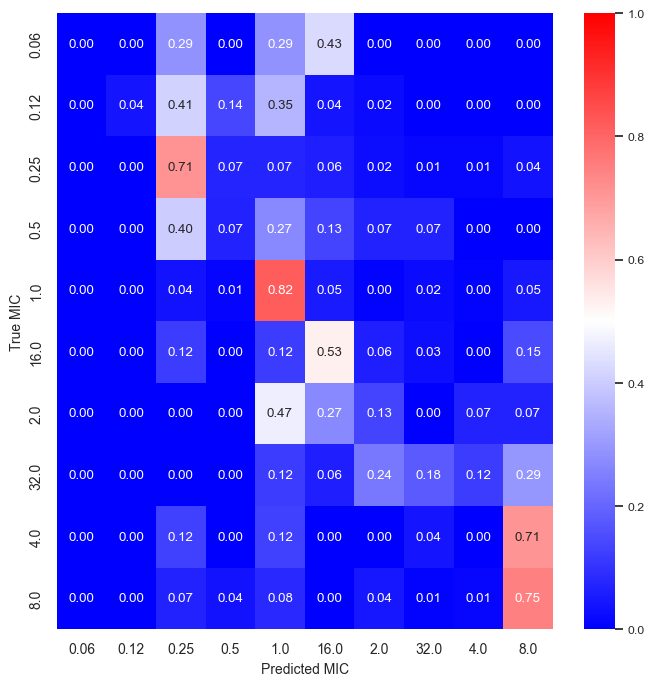

In [53]:
# Train the model
model.fit(X_train_np, y_tr_oc, epochs=50, batch_size=16, validation_data=(X_test_np, y_te_oc), verbose=False)
y_hat = prediction2label_nn(model.predict(X_test))
results_report(y_test, y_hat, le)